# Embeddings and Transformers
Goals of this lecture are:
* understand word embeddings
* fine-tune a BERT model for text classification 
* visualize BERT embeddings
* understand multimodal embeddings from CLIP 
* use CLIP for a image-to-text retrieval system
* implement a text-to-text retrieval system with the universal sentence encoder model

## Structure of this Notebook
In this lecture, we begin by analyzing and understanding a pre-trained word2vec model that was used in earlier modern NLP systems before transformer models were released. We still use word2vec here to get a basic understanding of how words can be represented in neural networks and why transformer models have an advantage over word2vec embeddings.

After analyzing the word2vec embeddings, we fine-tune a BERT model on the provided German news dataset and visualize the BERT embeddings to get a better understanding of the differences.

The next major step after transformers for language modeling was the CLIP model, which combines text with images. We analyze the CLIP embeddings for different datasets and get an idea of why CLIP can be used for zero-shot classification of image data without fine-tuning the model on new data. We then use the CLIP model to find for given images, suitable news messages.

In the last part of this lecture, we implement a text-to-text retrieval system by first understanding why CLIP is not well suited for text-to-text retrieval, and then using the universal sentence encoder model for retrieving text passages.

This notebook will show you how easily these models can be used with the [HuggingFace](https://huggingface.co/) and [SentenceTransformers](https://www.sbert.net/) libraries, which provide a high-level interface to the aforementioned models. This lecture is primarily about understanding the concept of embeddings rather than how to define your own architecture and train it.

First, however, we start by explaining the history and evolution of text representations for machine learning algorithms.

Reuqired libraries:
```
conda install numpy scipy
conda install scikit-learn
conda install numba
pip install umap-learn
pip install plotly
pip install 'transformers[torch]'
pip install sentence-transformers
pip install gensim
````


## Overall Picture and Evolution Path of Word Embeddings

The conventional way of modelling documents in tasks like information-retrieval, document-clustering, document-classification, sentiment-analysis, topic-classification is to represent each document as a **Bag-Of-Word**-vector $$\mathbf{d}_i=(tf_{i,0},tf_{i,1},\ldots tf_{i,|V|}).$$ Each component of this vector corresponds to a single term $j$ of the underlying vocabulary $V$ and the values $tf_{i,j}$ counts the frequency of term $j$ in document $i$. Instead of the term-frequency $tf_{i,j}$ it is also possible to fill the BoW-vector with 
* a binary indicator which indicates if the term $j$ appears in document $i$
* the tf-idf-values $$tfidf_{i,j}=tf_{i,j} \cdot log \frac{N}{df_j},$$ where $df_j$ is the frequency of documents, in which term $j$ appears, and $N$ is the total number of documents.

Independent of the values used, the BoW model represents sets of documents as 2-dimensional numeric arrays, which can easily be passed to conventional Machine Learning algorithms, such as Logistic Regression, SVM, MLPs etc. However, the major drawbacks of this approach are:
* the order by which terms appear in the document is totally ignored
* semantic relatedness of terms is not modelled
* BoW- vectors are very long and sparse 

As sketched in the picture below, today all of these drawbacks can be circumvented by representing the words of the document by their word-vectors and passing the corresponding sequence of word vectors in order to either a CNN or a Recurrent Neural Network such as LSTM or GRU. 

<img src="./Pics/overAllPicture.png" style="width:600px" align="middle">


---
## Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

## Submission

Upload your complete Notebook to the Ilias course until the start of the next lecture. One Notebook per group is sufficient. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Geoffrey Hinton    |
| 2.         | Yoshua Bengio      |
| 3.         | Yann LeCun         |
| 4.         | Jürgen Schmidhuber |
---

## Imports ##

In [51]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import numba
import umap
import gensim
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import plotly
import plotly.express as px
import plotly.graph_objs as go
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification, BertConfig, TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from datasets import load_dataset
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms as T
os.environ["WANDB_DISABLED"] = "true"
%matplotlib inline


## Part 1: Tasks on Word Embeddings

Word Embeddings for many languages can be downloaded for example from e.g. [FastText](https://fasttext.cc/docs/en/english-vectors.html). After downloading they can be imported into Python as described in [DSM.ipynb](DSM.ipynb). We use pretrained word2vec embeddings trained on [Common Crawl](https://commoncrawl.org/) and [Wikipedia](https://www.wikipedia.org/). Please download the binary model for the German language from: https://fasttext.cc/docs/en/crawl-vectors.html#models


In [89]:
from gensim.models.fasttext import load_facebook_model

model = load_facebook_model('/Users/milosaleksic/Downloads/cc.de.300.bin')

KeyboardInterrupt: 

Please explain the meaning of `CBOW`, `dimension 300`, `n-grams of length 5`, `window of size 5` and `10 negatives` that were used for training of the provided word2vec models from this sentence:

"These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives." (adapted from https://fasttext.cc/docs/en/crawl-vectors.html)



#### Elaboration 
**This sentence describes the training process of word2vec models using a set of specific parameters**

**(Continuous Bag of Words)**: CBOW is an architecture used for training word2vec models. It predicts a target word based on the context words surrounding it. In this case, "CBOW with position-weights" indicates that the model not only uses the context words but also takes into account their positions relative to the target word.

**Dimension 300**: This refers to the size of the word embeddings generated by the model. Word embeddings are vector representations of words in a continuous vector space. In this case, each word is represented by a 300-dimensional vector.

**N-grams of length 5**: An n-gram is a contiguous sequence of n items from a given sample of text or speech. In this case, character n-grams of length 5 are used, meaning the model considers sequences of 5 consecutive characters while training. This helps in capturing meaningful subword information and handling out-of-vocabulary words better.

**Window of size 5**: The window size determines the number of context words considered around the target word. A window of size 5 means the model takes into account 5 words on both sides of the target word (5 words before and 5 words after) during training.

**10 negatives**: This refers to the number of negative samples used in the Negative Sampling technique employed during training. Negative Sampling is a method used to optimize the training process by selecting a small number of negative samples (words that are not in the context) for each positive sample (the actual context words). In this case, for every positive sample, 10 negative samples are randomly chosen to update the model's weights during training.

### Using Word Embeddings

#### Task 1: Meta information of the learned Word Embedding
For the word2vec-model display the following parameters:
* number of different words in the learned word2vec-model
* length of the word2vec-vectors
* context-length, applied in training the model

#### Task 2: Access Word Embeddings
Display the first 10 components of the vectors of words
* *hochschule*
* *universität*
* *anstalt*

What do you observe?

Display the words (not the word-vectors) at indices 0 to 49 of the Word-embedding. What do you observe?

### Analyse Word Similarities

#### Task 3: Most similar words
For a German word of your choice, display the 20 most similar words.

For a pair of German words of your choice, display their similarity-value.

For two sets of German words of your choice, display their similarity-value.

#### Task 4: Word Relations
Apply the Word Embedding in order to answer the following questions:
* *Mann is to König as Frau is to ?*
* *Paris is to Frankreich as Berlin is to ?*
* *Student is to Hochschule as Arbeiter is to ?*

#### Task 5: Outliers
Apply the Word Embedding in order to determine the outlier within the following set of words: *auto, motorrad, kran, essen*. 

### Visualize Word Embeddings
The following code-cell visualizes similarities of words from index 300 to 499 by transforming the high-dimensional word-vectors into a 2-dim space. The transformation is realized by [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction](https://umap-learn.readthedocs.io/en/latest/).

In [ ]:
umap_model=umap.UMAP(n_components=2,random_state=0)
model2d=umap_model.fit_transform(model.wv[model.wv.index_to_key[300:500]])


plt.figure(figsize=(19,14))
idx=0
for a in model2d[:300]:
    #w=model.wv.index2word[300+idx].decode('utf-8')
    w=model.wv.index_to_key[300+idx]
    plt.plot(a[0],a[1],'r.')
    plt.text(a[0],a[1],w)
    idx+=1
plt.show()

#### Task 6: Visualize similarities of selected target words and their neighbors
For each of the word in the list `targetwords` calculate the 10 nearest neighbors. Then apply the same procedure as in the code cell above in order to visualize the similarities between all words in `wordset`, where `wordset` contains the target words and for each target word the 10 nearest neighbors. What do you observe? 

In [ ]:
# eigene targetwords wählen

----

## Part 2: Using Transformers for Text Classification

In recent years Transformers have received increasing attention. Therefore we use the popular [Hugging Face Framework](https://huggingface.co/docs/transformers/model_doc/bert) to fine-tune a BERT model on our custom dataset.
The classifier shall be able to distinguish RSS-feed news with technical content from general RSS-feed news. Training and evaluation data is available from the folder `./Data/GERMAN/`.

Recap BERT Lecture: [MLBook](https://maucher.pages.mi.hdm-stuttgart.de/mlbook/transformer/attention.html#bert)

Hugging Face provides thousands of different pretrained models for NLP, Visison or other tasks. They also have a [blog](https://huggingface.co/blog) and a [NLP Course](https://huggingface.co/course/chapter1/1) with Transformers.

In this task we will use a the pretrained [Bert Model from deepset.ai](https://www.deepset.ai/german-bert) that was trained for hate speech detection on the GermEval18Coarse dataset and fine-tune it on our own classification task. Hugging Face provides a tutorial for a similar task in the [documentation](https://huggingface.co/transformers/v3.2.0/custom_datasets.html#sequence-classification-with-imdb-reviews). The model name used for loading the model from the library is: `deepset/bert-base-german-cased-hatespeech-GermEval18Coarse`

First we need to install the Transformers library:

In [ ]:
#!pip install transformers[torch]

In [ ]:
# check text classification models <here: https://huggingface.co/models?filter=text-classification
BERT_MODEL_NAME = "deepset/bert-base-german-cased-hatespeech-GermEval18Coarse"

We set the environment variable `WANDB_DISABLED` to true so that Hugging Face is not automatically trying to connect to a Weigths & Biases account. 

[Weights & Biases](https://wandb.ai/) is a machine learning platform for developers to build models faster. It provides tools to track experiments and datasets, evaluate model performance, reproduce models, visualize results etc.

### Access locally stored RSS-feed news of both categories 
News crawled from RSS feeds of category `Tech` and `General` are stored in distinct directories. In the following code-cell the paths to both directories are configured. 

In [4]:
techpath="./Data/GERMAN/TECH/RSS/FeedText"
generalpath="./Data/GERMAN/GENERAL/RSS/FeedText"
catpaths=[techpath,generalpath]

The specified directory `techpath` must contain a list of directories. The name of each of these directories is the name of the feed, from which the news are crawled attached by the date of crawling. For example one subdirectory may be `golem-2017-11-07`. Each of this feed-and-date-specific subdirectories conatins one or more `.txt`-files. The name of each of these `.txt`-files is of format `hh-mm.txt`, i.e. it contains the daytime of crawling. If one feed is crawled multiple times per day, the feed-and-date-specific subdirectories will contain more than one `.txt`-files, each identified by the time of crawling. Below, the first lines of a sample `.txt`-file, `15-15.txt` from directory `golem-2017-11-07` are shown. Each paragraph of the file is a single news item from the *golem RSS feed*, crawled at 2017-11-07, 15.51h.

![Screenshot of feedfile](./Pics/feedfile.png)



In the following code-cell all news from all files are imported. All news from subdirectories of `techpath` are assigned to the class `Tech` (label 0) and all news from subdirectories of `generalpath` are assigned to class `GENERAL` (label 1). Each news-item is represented as a list of words, contained in the item. All item-specific word-lists are assigned to the list `texts` and the corresponding class-indices are assigned to the list `labels`. Before news-item specific word lists are appended to the `texts`-list it is checked, if they are not yet contained in this list.  

In [5]:
# second, prepare text samples and their labels
print('Processing text dataset')
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for catlabel,categorypath in enumerate(catpaths):
    for name in sorted(os.listdir(categorypath)):
        feedpath = os.path.join(categorypath, name)
        if os.path.isdir(feedpath):
            #print(name)
            for fname in sorted(os.listdir(feedpath)):
                fpath = os.path.join(feedpath, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='utf-8')
                t = f.read()
                news=t.split('\n \n')
                for entry in news:
                    if (len(entry)>50) and (entry not in texts): #remove duplicates
                        #if entry not in texts:
                        texts.append(entry)
                        labels.append(catlabel)
                f.close()
print('Found %s texts.' % len(texts))

Processing text dataset
Found 3315 texts.


In [6]:
print(texts[0])
print("-"*20)
print(texts[1])
print("-"*20)
print(texts[2])

Gestaltungstipps: T-Shirts bedrucken
Bedruckte T-Shirts sind ein All-Time-Favorite – egal, ob witzige Comic-Motive oder schlichte Formen. Tipps und Ideen rund um die Gestaltung.
--------------------
Software-Charts: Die 50 Top-Downloads des Monats
CCleaner ist gehackt, die sichere neue Fassung laden Sie hier – samt Vollversionen: das Ashampoo Music Studio und PowerDirector.
--------------------
Quereinsteiger-Jobs: So gelingt der Wechsel
Der Quereinstieg in eine neue Branche ist heute nicht mehr ungewöhnlich. Fragen und Tipps, die beim beruflichen Neustart helfen können.


#### Task 0: Visualize distribution of document lengths
Visualize the distribution of the number of words in all documents in a histogram.

In [ ]:
# Step 1: Visualize the distribution of the number of words in all documents in a histogram
word_counts = [len(text.split()) for text in texts]
plt.hist(word_counts, bins=50)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

#### Task 1: Load the Data into a custom Dataset  

#### Convert texts to sequence of integers

Apply the [BertTokenizer](https://huggingface.co/docs/transformers/v4.16.2/en/model_doc/bert#transformers.BertTokenizer) in order to uniquely map each word to an integer-index and to represent each text (news-item) as a sequence of integers. For more information, see the [Tokenizer-chapter](https://huggingface.co/course/chapter2/4?fw=pt) in the NLP course. Afterwards we load the custom texts into a custom Dataset. Also define the `max_length` of the sequences and use padding and truncation. We first need to split the dataset into a train and test split and then apply the tokenizer on the splits. 

In [ ]:
# initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
# use the BERT tokenizer to uniquely map each word to an integer-based index and to represent each text (news-item) as a sequence of integers
input_ids = [tokenizer.encode(text, add_special_tokens=True) for text in texts]


In [ ]:
print(input_ids)

Then a custom Dataset can be created for training of the model. We will use a PyTorch Dataset here, as this model was trained with PyTorch and also to show that using the library with PyTorch is quite simple even though we have not used PyTorch in this course. In addition more PyTorch models are hosted on hugging face than Tensorflow models.

In [ ]:
# Custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": label,
        }

#### Task 2: Define the Bert Model
Next we can create a [Bert Model for Sequence Classification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification) with the pretrained weights from the previously definded `BERT_MODEL_NAME`. We can use GPU support for training the model by calling `model = model.to('cuda')` after loading the model. This is, however, not necessary as the dataset is quite small and we also do not need to train the model for many epochs. 

For training the Bert-Model on a custom task we also need to set the custom number of the labels and also the flag `ignore_mismatched_sizes` to true. The parameters which can be set are listed in the [PretrainedConfig](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/configuration#transformers.PretrainedConfig).

In [ ]:
# Create a BertConfig object with custom parameters
config = BertConfig.from_pretrained(BERT_MODEL_NAME
                                    ,num_labels=2, # number of clases: Tech and General
                                    ignore_mismatched_sizes=True)

# Create a Bert Model for Sequence Classification
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, config=config)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

The ignore_mismatched_sizes flag, when set to True, tells the model to ignore any mismatch between the size of the pretrained weights and the size of the model weights during the initialization process. This can be useful when you want to adapt a pretrained model to a new task with a different number of labels, as the final layer's dimensions might not match exactly.

#### Task 3: Define Training Arguments and train the Model
Hyperparameters for training a Hugging face Transformer Model are defined in a [TrainingArguments](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments)-Object. We can mostly use the default arguments, but choose an appropriate batch size. Two epochs is already enough for finetuning of the model.

Additonally, we set the `evaluation_strategy`and `save_strategy` to `epoch` to make the model predicitons comparable with the CNN and LSTM-architecture. You also need to define a suitable value for `logging_steps`. This value should be smaller than the steps needed to complete an epoch as otherwise no values will be logged in the first epochs.

We can specifiy which inputlenght to use.
Approaches to determin the maximum lenght of the input sequence are

1. From the text and determine the max. lenght algorithmically: 

In [ ]:
#determine the maximum length of the input sequences
max_len = 0
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max length: ', max_len)


2. Many pre-trained models have a maximum sequence length they can handle, typically 512 tokens for BERT-like models. You can set your max_length to this value or lower, depending on the dataset and computational resources. 

In [ ]:
bert_max_length = 512

3. A statistical appraoch. Analyze the distribution of sequence lengths in the dataset. Calculate the mean, standard deviation, and percentiles (e.g., 90th, 95th, 99th) of the sequence lengths. Based on these statistics, one can choose a suitable max_length that captures the majority of the data while not being too large, which could lead to unnecessary padding and increased computation time. For example, if the 95th percentile of your sequence lengths is 150 tokens, you might choose a max_length of 150-200 tokens.

In [ ]:
sequence_lengths = [len(tokenizer.encode(text)) for text in texts]
mean_length = np.mean(sequence_lengths)
std_length = np.std(sequence_lengths)
percentile_90 = np.percentile(sequence_lengths, 90)
percentile_95 = np.percentile(sequence_lengths, 95)
percentile_99 = np.percentile(sequence_lengths, 99)

print(f"Mean: {mean_length}, Standard Deviation: {std_length}")
print(f"90th percentile: {percentile_90}, 95th percentile: {percentile_95}, 99th percentile: {percentile_99}")

for this task we will use the calculated max lenght of 133

Now we instantiate a [Trainer](https://huggingface.co/transformers/v3.2.0/main_classes/trainer.html#transformers.Trainer) with the defined model, training arguments and both datasets: 

In [ ]:
# Split the dataset into train and test splits
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Apply the tokenizer on the splits with padding and truncation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_len)

In [ ]:
# Define the TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    logging_dir="./logs",
)

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Finally we can train the model:

In [ ]:
trainer.train()

#### Task 4: Add an Evaluation Metric while Training the Model
As you should have already noticed, by default Hugging Face returns only loss and no other metrics. To get metrics for our training epochs, we should set the `compute_metrics` parameter of the Trainer. Define a function with the approriate metrics so that you can compare your metrics to the previous models. An example of a compute metrics function can be found [here](https://huggingface.co/transformers/v3.0.2/training.html#trainer).

Then retrain your model and interpret the training results.

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("./trained_models")

# Part 3: Visualize BERT embeddings

#### Task 1: Bert for Inference and compare example Sentences
After the model is trained, we can visualize the embeddings for the dataset and use the model for inference. For getting the hidden states of the model prediciton, you have to pass `output_hidden_states=True` to the forward/call method of the model. Additionally, you can pass `return_dict=True` to get a [BaseModelOutput](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/output#transformers.modeling_outputs.BaseModelOutput)-object, where you can then access the `last_hidden_state`-attribute.  

To understand the difference of the embeddings, you can use two example sentences where one word in the middle differs and compare the embeddings of both sentences. 
For comparing the two example sentences use `torch.isclose(first_sentence, second_sentence, atol=1e-05)` [Doc](https://pytorch.org/docs/stable/generated/torch.isclose.html). The `atol` parameter controls which numerical precision satsifies the `isclose` condition.

What can you observe in contrast to the word2vec embeddings? What is the main difference? 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("./trained_models")

In [ ]:
input_1 = tokenizer.encode("The car is blue", return_tensors="pt")

output_1 = model(input_1, output_hidden_states=True, return_dict=True)

input_2 = tokenizer.encode("The house is blue", return_tensors="pt")

output_2 = model(input_2, output_hidden_states=True, return_dict=True)

print(output_1.last_hidden_state.size())
print(output_2.last_hidden_state.size())

#### Task 2: Create Embeddings for whole Dataset

Now we can create the embeddings for the entire dataset. Store the embeddings in a list so that we can visualize the embedding space. We need to use a dimensional reduction method like UMAP, which was used previously to visualize the word2vec embeddings. Average the embeddings over the first dimension so that we get a 2-dimensional tensor with `(number of texts, size of bert embedding)`.

For visualization, we can use a [Plotly scatter plot](https://plotly.com/python/line-and-scatter/). To analyze which sentences are close to each other in the embedding space, set the news text as hover data. Display only the first 100 characters of the news article, otherwise the hover box will be to large.

# Part 4: Visualize CLIP embeddings

This part was inpsired by: https://medium.com/mlearning-ai/having-fun-with-clip-features-part-i-29dff92bbbcd

After covering the differences of the transformer and word2vec embeddings, we will analyze the multimodal embeddings generated from the [OpenAI CLIP](https://openai.com/research/clip). Unlike GPT-4 the CLIP model was still released open source with pretrainend weights. We will use the pretrained weights, so we do not need to finetune the model. 

The main goal of this chapter is to understand why CLIP can be used for zero-shot classification on image datasets. Therefore, we analyze two different datasets, [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and the good old [MNIST](https://paperswithcode.com/dataset/mnist) dataset. 


## CLIP Overview
CLIP, Contrastive Language-Image Pre-training, was trained on over 400M image and text pairs collected from publicly available resources on the internet. A text-image pair consists of the image and a caption. You can think of the caption as the description of the image, such as when someone uploads a picture to Instagram and briefly describes what she/he is doing. 

<img src="Pics/clip-training.svg" width=500/>
The figure above shows an overview of the training objective. During training, CLIP is incentivized to match each image in the current batch to the correct caption. Then the loss for both encoders is calculated and backpropagated. This pushes the representation ob both encoders onto a common latent space. All other examples in the current batch are negative examples, as the caption doesn't fit to the image. This is called contrastive learning. The goal of contrastive learning is to learn representations in which the embeddings of similar instances are close to each other, while different instances are further away. 

For using CLIP in a zero-shot way to classify datasets, we generate text prompts for all classes in the style of `a photo of a {class_name}`. Then embeddings are created for all images and text prompts. To classify which image belongs to which class, the cosine similarity between the text prompts and image embeddings is calculated and the text prompt with the highest similarity is selected. See also the following image:
<img src="Pics/clip-overview.svg" width=500 />
(both pictures from https://openai.com/research/clip)

## Projection onto the same embedding space
We will use UMAP again for dimensional reduction. Unlike the visualization of the BERT and word2vec embeddings, CLIP consists of two different encoders, one for the image and one for the text. UMAP is able to map the embedding spaces of both encoders onto the same embedding space by first fitting and transforming the embedding space of the image dataset, and then using the fitted UMAP model to map the text embedding space onto the image embedding space. 

We will provide a function for plotting the text prompts into the embedding space, as this is a bit more complicated, to get matching colors for the text prompts and the labels of the images. It is also necessary to sort the image embeddings by the labels, before plotting the data. This ensures, that we can match the colors of the text prompts and the images. 

From now on we will also use the [SentenceTransformers](https://www.sbert.net/) library, which is another abstraction of the HuggingFace library and thus also easier to use. For further information on how to use CLIP with the SentenceTransformer library, see the [docs](https://www.sbert.net/examples/applications/image-search/README.html).

The CLIP model can be loaded with the name `clip-ViT-B-32`.


In [66]:
#Load CLIP model
model = SentenceTransformer('clip-ViT-B-32')

#### Plot text-prompt embeddings ####

This function plots the low dimensional text prompts embeddings 
onto the same figure with a x marker to distinguish them from the image embeddings

Parameters:
* low_dim_text_embeddings: the 2-dimensional text prompt embeddings after the UMAP transform
* figure: the plotly figure, returned by the px.scatter function
* classes: the sorted classes of the dataset

In [65]:
def plot_text_prompt_embeddings(low_dim_text_embeddings, figure, classes):
    l, c = len(px.colors.qualitative.Plotly), len(low_dim_text_embeddings)
    df, colors = pd.DataFrame(low_dim_text_embeddings), (px.colors.qualitative.Plotly * ((c // l) + 1))[:c]
    figure.add_scatter(x=df[0], y=df[1], hovertext=classes, mode='markers', marker={'symbol':
                   'x', 'size':20, 'color': colors, 'opacity':0.8, 'line': dict(width=2, color="DarkSlateGrey")})

#### Load embeddings
This function should load a dataset with a given name from the HuggingFace datasets
and create the embeddings for the images and class labels.
You need to create the automatic text prompts in the style of "a photo of a {class_name}" for each class.

It is also sufficient to plot a large enough subset of the data. 
n=1280 is already good enough to see, how the embedding space is clustered.
It could be that the keys in which the images are stored are not always the same.

Parameters:
* name: the name of the dataset, e.g. 'cifar10' or 'mnist'
* n: the number of images for which embeddings should be created.
    
Return: image embeddings, text embeddings, labels 


In [ ]:
def load_embeddings_for_dataset(name, n=1280):
    
    # check if the embeddings were already created
    if os.path.exists('img_emb_file') and os.path.exists('text_emb_file'):
        pass
         
    else:
        # create new embeddings for the text prompts and images
        # and store them on the disk so that we not always need to calculate the embeddings
        pass
        
    return # image embeddings, text embeddings, labels 

In [87]:
def load_embeddings_for_dataset(name, n=1280):
    img_emb_file = f"{name}_img_embeddings.npy"
    text_emb_file = f"{name}_text_embeddings.npy"
    labels_file = f"{name}_labels.npy"

    if os.path.exists(img_emb_file) and os.path.exists(text_emb_file) and os.path.exists(labels_file):
        img_embeddings = np.load(img_emb_file)
        text_embeddings = np.load(text_emb_file)
        labels = np.load(labels_file)
    else:
        dataset = load_dataset(name, split=f"train[:{n}]")
        
        # Handle different column names for the image data
        img_column = "image" if "image" in dataset.column_names else "img"
        
        if name == 'mnist':
            images = [Image.fromarray(img, mode="L") for img in dataset[img_column]]
        else:
            images = [Image.fromarray(img) for img in dataset[img_column]]
            
        labels = dataset["label"]

        img_embeddings = model.encode(images)
        text_prompts = [f"a photo of a {label}" for label in labels]
        text_embeddings = model.encode(text_prompts)

        np.save(img_emb_file, img_embeddings)
        np.save(text_emb_file, text_embeddings)
        np.save(labels_file, labels)

    return img_embeddings, text_embeddings, labels



#### Plot embeddings

This function transforms the data so that we can plot them. 
First, use UMAP to reduce the embeddings into 2 dimensions.
Then use px.scatter to plot the image embeddings, use the class labels as the color of the data point.

Parameters:
* img_embeddings: the image embeddings from the CLIP model
* text_embeddings: the text embeddings from teh CLIP model
* labels: the labels for the images


In [77]:
def plot_embeddings(img_embeddings, text_embeddings, labels):
    reducer = umap.UMAP()
    low_dim_img_embeddings = reducer.fit_transform(img_embeddings)
    low_dim_text_embeddings = reducer.transform(text_embeddings)

    classes = sorted(set(labels))
    fig = px.scatter(x=low_dim_img_embeddings[:, 0], y=low_dim_img_embeddings[:, 1], color=labels, labels=classes)

    plot_text_prompt_embeddings(low_dim_text_embeddings, fig, classes)
    fig.show()


In [ ]:
def plot_embeddings(img_embeddings, text_embeddings, labels):
    # use UMAP to reduce the dimensionality of the image data
    
    # plot the low dim data

    #plot_text_prompt_embeddings(low_dim_text_embeddings, fig, classes)

    #fig.show()
    pass    

### Task 1: CIFAR10 Dataset

The evaluation of the CIFAR10 dataset. Can you draw some conclusions about CLIP and the dataset?

In [78]:
img_embeddings, text_embeddings, labels = load_embeddings_for_dataset('cifar10')

In [79]:
plot_embeddings(img_embeddings, text_embeddings, labels)

### Task 2: MNIST dataset
The evaluation of the MNIST dataset. Can you draw some conclusions about CLIP and the dataset?

In [88]:
img_embeddings, text_embeddings, labels = load_embeddings_for_dataset('mnist')

Found cached dataset mnist (/Users/milosaleksic/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


TypeError: expected string or buffer

In [ ]:
plot_embeddings(img_embeddings, text_embeddings, labels)

### Task 3: Custom Dataset

After analyzing the CIFAR10 and MNIST dataset, perform the same evaluation on a dataset of your choice. 

# Part 5: Text and Image Retrieval System

In this section, we will use CLIP to match images to news articles. Therefore, we need to create text embeddigs for the whole dataset. As we are working with German news articles, we have to use the multilingual version of CLIP with the model name `clip-ViT-B-32-multilingual-v1` for encoding the text. For the images, we still use the same model as before `clip-ViT-B-32`. For this notebook, it is not necessary to understand the details of how the CLIP text encoder was adapted to more languages, but if this topic is of interest, you can read the paper here: [Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation](https://arxiv.org/abs/2004.09813)

As an side experiment, we will also try to use CLIP for text-to-text retrieval and check if it is possible to use CLIP for zero-shot text classification.

### Task 1: Create embeddings for all news articels with the CLIP text encoder

The maximum sequence length of the CLIP text encoder is unfortunately not very long, but we can simply truncate the news article to the first 170 characters so that the text encoder can create embeddings for all articles.

In [7]:
# Here we load the multilingual CLIP model. Note, this model can only encode text.
# If you need embeddings for images, you must load the 'clip-ViT-B-32' model
text_encoder = SentenceTransformer('clip-ViT-B-32-multilingual-v1')
image_encoder = SentenceTransformer('clip-ViT-B-32')


#### Create text embeddings #####

Preprocess texts

In [8]:
# Truncate the articles to the first 170 characters
truncated_texts = [text[:170] for text in texts]

# Encode the truncated articles using the CLIP text encoder
text_embeddings = text_encoder.encode(truncated_texts)


In [9]:
text_embeddings

array([[ 0.18420517,  0.2595311 , -0.28265524, ..., -0.29740694,
         0.07063062,  0.16765581],
       [ 0.01088649,  0.41641152, -0.0788433 , ...,  0.05296072,
         0.04180558,  0.2438907 ],
       [ 0.16143334, -0.05314098, -0.1559599 , ...,  0.26906696,
         0.09155048,  0.02269072],
       ...,
       [ 0.04239892, -0.01383953, -0.05396393, ...,  0.20458643,
        -0.0082223 , -0.14982171],
       [ 0.23562847,  0.03184715, -0.19309717, ...,  0.3367804 ,
         0.24543071,  0.14634229],
       [ 0.112553  ,  0.0978174 , -0.06243617, ...,  0.3196776 ,
         0.00554909,  0.10435576]], dtype=float32)

In [10]:
text_embeddings.shape

(3315, 512)

In [11]:
text_embeddings.__class__

numpy.ndarray

In [12]:
np.save('text_embeddings.npy', text_embeddings)

#### Create Image Embeddings #####

#### <font color="blue"><b>Comment:</b></font> In the case of CLIP, the preprocessing steps usually include:

1. Resizing: The images are resized to match the input size expected by the model. For CLIP, this is typically 224x224 pixels.

2. Converting to a tensor: The image is converted from the PIL Image format to a PyTorch tensor, which is the required input format for the model.

3. Normalizing: The image's pixel values are normalized to have zero mean and unit variance. This is done using predefined mean and standard deviation values calculated from the training dataset. Normalization helps the model generalize better and improves training convergence.

In [13]:
image_dir = "./Unsplash_pics"
image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

In [202]:
""""
# Preprocess the images
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

In [14]:
images = [Image.open(img).convert('RGB') for img in image_files]

In [15]:
images

[<PIL.Image.Image image mode=RGB size=3024x4032>,
 <PIL.Image.Image image mode=RGB size=3600x2400>,
 <PIL.Image.Image image mode=RGB size=5856x3783>,
 <PIL.Image.Image image mode=RGB size=5184x3888>,
 <PIL.Image.Image image mode=RGB size=3369x4211>,
 <PIL.Image.Image image mode=RGB size=6000x4000>,
 <PIL.Image.Image image mode=RGB size=4157x2771>,
 <PIL.Image.Image image mode=RGB size=4898x3265>,
 <PIL.Image.Image image mode=RGB size=4800x3200>,
 <PIL.Image.Image image mode=RGB size=6172x4469>,
 <PIL.Image.Image image mode=RGB size=1908x3702>,
 <PIL.Image.Image image mode=RGB size=6000x4000>,
 <PIL.Image.Image image mode=RGB size=4288x2848>,
 <PIL.Image.Image image mode=RGB size=4032x5040>,
 <PIL.Image.Image image mode=RGB size=3456x2304>,
 <PIL.Image.Image image mode=RGB size=3064x4592>]

In [16]:
# Encode the preprocessed images using the CLIP image encoder
image_embeddings = image_encoder.encode(images)

In [17]:
image_embeddings

array([[ 0.2511615 ,  0.22958213,  0.07403965, ..., -0.16366561,
        -0.09852522, -0.17212337],
       [-0.15026219, -0.13955316,  0.4028667 , ...,  0.16265434,
        -0.10917479, -0.14247982],
       [-0.1593688 ,  0.34506145, -0.19240037, ...,  0.63743675,
        -0.08614636, -0.6249295 ],
       ...,
       [-0.09634256,  0.78715163, -0.25827843, ...,  0.02994686,
         0.330897  , -0.17762278],
       [-0.21035117,  0.27038276, -0.36035126, ...,  0.09905837,
         0.20193097, -0.6010582 ],
       [ 0.03506469, -0.33923417, -0.21166658, ...,  0.10866472,
        -0.00956031,  0.34842578]], dtype=float32)

In [18]:
image_embeddings.shape

(16, 512)

In [19]:
image_embeddings.__class__

numpy.ndarray

In [20]:
np.save('image_embeddings.npy', image_embeddings)

In [21]:
# Load the saved embeddings
text_embeddings = np.load('text_embeddings.npy')
image_embeddings = np.load('image_embeddings.npy')

### Task 2: Match News Articles to Images

Define a function `show_news_for_img(img_path, topk=5)`, which takes an image path as input and an integer `topk` that defines how many of the best matching news articles should be displayed. For evaluation, you can select some example images (minimum 5) from [Unsplash](https://unsplash.com/) and analyze how good the best 5 news articles match to the image.

The function should always display the image and afterwards the topk news articles and the similarity of the news article and image.

For calculating which news article fits best to an image, use the [cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) metric provided from Scikit-learn. 

In [61]:
def show_news_for_img(img_path, topk=5):
       # Load the input image
    input_img = Image.open(img_path)

    # Create an embedding for the input image
    with torch.no_grad():
        input_img_embedding = image_encoder.encode([input_img])[0]

    # Reshape the input_img_embedding
    input_img_embedding = input_img_embedding.reshape(1, -1)

    # Calculate the cosine similarity between the input image embedding and all text embeddings # 
    # By calling flatten() on the similarities array, convert it into a one-dimensional array with a shape of (n,). This simplifies the process of finding the top-k most similar news articles, so that we can directly use the argsort() function to get the indices of the top-k highest similarity scores.
    similarities = cosine_similarity(input_img_embedding, text_embeddings).flatten()

    # Get the indices of the top-k most similar news articles
    topk_indices = similarities.argsort()[-topk:][::-1]

    # Display the input image
    plt.imshow(input_img)
    plt.axis('off')
    plt.show()

    # Display the top-k matching news articles and their similarity scores
    print(f"Top {topk} matching news articles:")
    for i, idx in enumerate(topk_indices, start=1):
        print(f"{i}. Similarity: {similarities[idx]:.4f}\n{texts[idx]}\n{'-' * 20}")


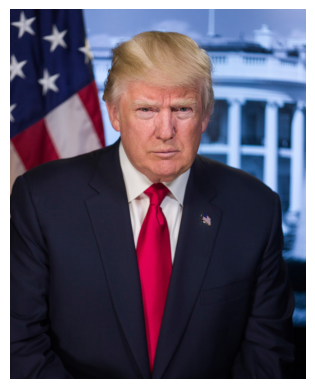

Top 5 matching news articles:
1. Similarity: 0.3032
26. Januar 2018: Diplomatie oder Krawall?
 Was für einen Auftritt wird US-Präsident Trump beim Weltwirtschaftsforum hinlegen? Außerdem im Podcast: Die miserable Lage der Drehbuchautoren könnte sich nun bessern.
--------------------
2. Similarity: 0.3010
USA: Präsident nominiert Kirstjen Nielsen als neue Heimatschutz-Chefin
Donald Trump will die Krisenexpertin Kirstjen Nielsen zur neuen Heimatschutzministerin machen. Im Weißen Haus gilt sie als Aufräumerin.
--------------------
3. Similarity: 0.2914
US-Präsident: Ein Jahr Trump
 Steuerreform, Einreiseverbot, Nahostkonflikt: Donald Trump sorgt innen- und außenpolitisch für Schlagzeilen. Hier lesen Sie Nachrichten und Analysen zum US-Präsidenten.
--------------------
4. Similarity: 0.2904
Donald Trump: Der Clown wird zum Monster
 Dass Präsidenten nach einem Anschlag in die Justiz eingreifen und die Todesstrafe für Terroristen fordern, kennt man von Autokraten. Trump ist auf dem besten We

In [62]:
show_news_for_img('./Unsplash_pics/trump.jpg' , topk=5)


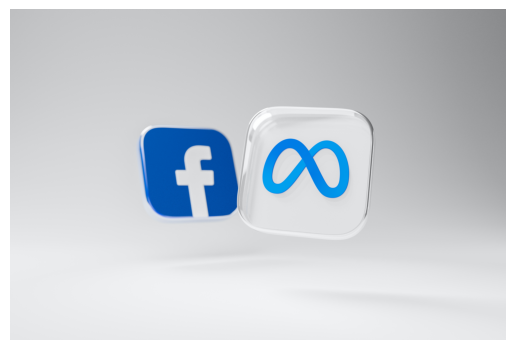

Top 5 matching news articles:
1. Similarity: 0.3027
Soziale Netzwerke: Maas rüstet personell gegen Facebook & Co. auf
Beim Bundesamt für Justiz sollen nach SPIEGEL-Informationen rund 50 Mitarbeiter die Umsetzung des Facebook-Gesetzes begleiten. Anfang Oktober soll bereits die Hälfte einsatzbereit sein.
--------------------
2. Similarity: 0.2982
Neue Algorithmen für Facebook: Weniger Nachrichten, mehr Persönliches
Statt "relevanter Inhalte" stehen bei Facebook fortan "bedeutsame Interaktionen" mit Menschen im Vordergrund. Das bedeutet mehr Katzen- und Babyfotos, weniger Nachrichten. User werden dann womöglich weniger Zeit auf Facebook verbringen.
--------------------
3. Similarity: 0.2958
Statt Docker und Kubernetes: Facebook braucht Tupperware für seine Container
Für seine eigenen Dienste verzichtet Facebook komplett auf Docker oder auch Kubernetes. Stattdessen nutzt das Unternehmen die Eigenentwicklung Tupperware für seine Container und setzt sonst auf Standard-Linux-Technik wie Syste

In [214]:
show_news_for_img('./Unsplash_pics/dima-solomin-yIT9HO8UrPA-unsplash.jpg' , topk=5)

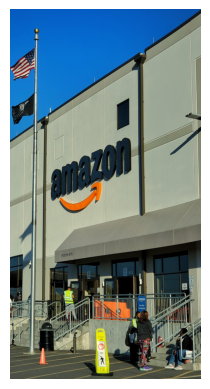

Top 5 matching news articles:
1. Similarity: 0.3352
Enormer Personalbedarf: Amazon sucht 13.000 Saisonarbeiter fürs Weihnachtsgeschäft
Amazon rüstet sich für das umsatzstarke Weihnachtsgeschäft: Der US-Handelsriese sucht in Deutschland 13.000 Saisonkräfte - was fast einer Verdopplung seiner Mitarbeiter entspricht.
--------------------
2. Similarity: 0.3231
Amazon: Hauseigene Produkte per Ratenzahlung kaufen
Sie interessieren sich für ein Amazon-Gerät, haben aber aktuell nicht genug Geld? Kein Problem – dank der neuen Amazon-Ratenzahlung.
--------------------
3. Similarity: 0.3179
Amazon: Alexa, wo sollen wir bauen?
 Der Onlinehändler plant den Bau eines zweiten Hauptsitzes in den USA. Mehr als 100 Städte hoffen auf Milliardeninvestitionen und neue Jobs. Zahlt sich die Rechnung aus?
--------------------
4. Similarity: 0.3144
Umstritten: Amazon senkt Preise seiner Händler
Ist ein Artikel zu teuer, kauft ihn keiner. Dagegen geht Amazon in den USA jetzt auch bei Händlern vor, die eigentlic

In [215]:
show_news_for_img('./Unsplash_pics/amazon.jpg' , topk=5)

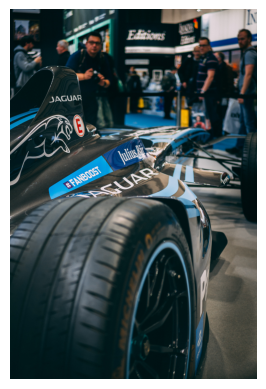

Top 5 matching news articles:
1. Similarity: 0.2744
Schnellstes Serienauto: Koenigsegg schlägt Bugatti
Kein Serienauto der Welt war bislang schneller: Der Agera RS von Koenigsegg erreichte mit seinen 1.176 PS nun eine neue Höchstgeschwindigkeit.
--------------------
2. Similarity: 0.2722
E-Auto-Batterien: Daimler-Ersatzteillager geht als Stromspeicher ans Netz
Eigentlich sind die Lithium-Ionen-Akkus von Daimler für Elektro-Smarts gedacht. Bis sie dort als Ersatzteil benötigt werden, kommen sie in Hannover als Stromspeicher zum Einsatz.
--------------------
3. Similarity: 0.2716
Live-Stream: So sehen Sie die Formel 1 live im Internet
Zum vorerst letzten Mal startet am Sonntag, 01. Oktober der Große Preis von Malaysia in Sepang. Wie Sie das Rennen im Internet verfolgen, steht hier.
--------------------
4. Similarity: 0.2697
TV-Hammer: Sky steigt bei Formel 1 aus!
Der Pay-TV-Sender Sky Deutschland verzichtet künftig auf die Formel 1 – und zeigt weniger Champions League. Die Infos!
-------

In [216]:
show_news_for_img('./Unsplash_pics/matt-seymour-3uu5_kn1k_Y-unsplash.jpg' , topk=5)

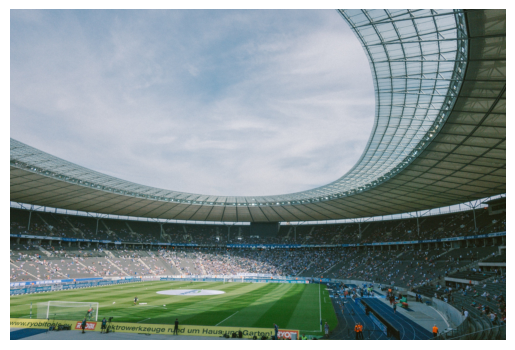

Top 5 matching news articles:
1. Similarity: 0.3030
Bundesliga im Liveticker: Schalke - Hannover
Nach den Patzern der Konkurrenz können die Königsblauen erster „Verfolger“ der Bayern werden. Mit Abgang Leon Goretzka in der Startelf geht es nun gegen Hannover. Verfolgen Sie das Spiel im Liveticker.
--------------------
2. Similarity: 0.3014
0:0 gegen Bremen – Krisen-Quälerei ohne Tor in Köln
Schlimmer geht‘s nimmer: Die Kellerkinder Köln und Bremen liefern sich zur besten Zweitligazeit ein Spiel auf niedrigem Niveau. Wenigstens ein FC-Spieler findet einen Trost in der Nullnummer.
--------------------
3. Similarity: 0.2998
Minusrekord
Die Welt ist ungerecht, sogar im Fußball. 12 500 Menschen waren am Sonntag im Grünwalder Stadion. Nicht nur sie verpassten Unterföhrings ersten Sieg.
--------------------
4. Similarity: 0.2978
Videobeweis: In vielen Sportarten längst etabliert
Seit dieser Saison wird der Videobeweis in der Fußball-Bundesliga eingesetzt – zunächst in einer Testphase. Vieles 

In [217]:
show_news_for_img('./Unsplash_pics/fionn-grosse-G5uasfXjZdc-unsplash.jpg' , topk=5)

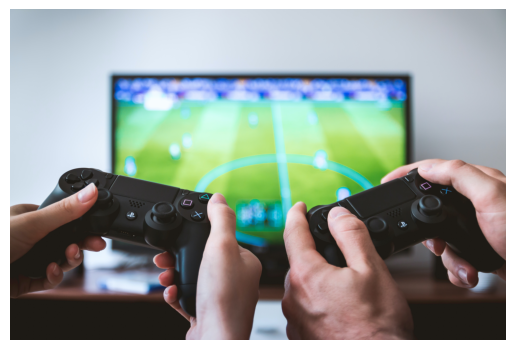

Top 5 matching news articles:
1. Similarity: 0.3209
„FIFA 18“ über eine Million Mal verkauft
Der Bundesverband "Interaktive Unterhaltungssoftware" (BIU) hat die meistverkauften Computerspiele ausgezeichnet. Nur wenige Tage nach der Veröffentlichung hat sich die Fußballsimulation „FIFA 18“ bereits über eine Million Mal verkauft. 
Ein Auszeichnung für über 200.000 verkaufte Spiele geht je an die Spaß-Raserei „Mario Kart 8 Deluxe“ für die Nintendo Switch und das Gruselabenteuer „Resident ...
--------------------
2. Similarity: 0.2935
FIFA 18 angespielt: Karacho-Fußball, auf Hochglanz poliert
Spielerisch tritt die Fußball-Simulation FIFA 18 auf der Stelle. Das ist zu verkraften, denn der jüngste Teil der Reihe hat anderes zu bieten: Top-Grafik, TV-Atmosphäre und den zweiten Teil des interaktiven Story-Kampagne The Journey.
--------------------
3. Similarity: 0.2902
FIFA 18: Die besten Tipps und Tricks vom Profi
Ein „FIFA 18“-Profi verrät seine besten Tipps: Der perfekte Torabschluss, Strat

In [218]:
show_news_for_img('./Unsplash_pics/jeshoots-com-eCktzGjC-iU-unsplash.jpg' , topk=5)

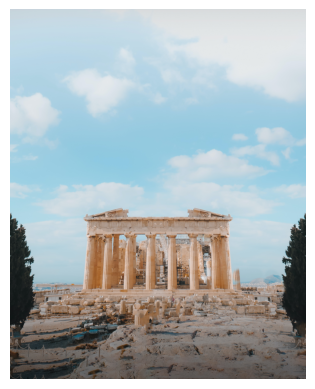

Top 5 matching news articles:
1. Similarity: 0.2938
Griechenland: Scharia-Rechtsprechung wird eingeschränkt
 In der griechischen Region Westthrakien ist das islamische Recht eingeschränkt gültig. Doch nun hat das Parlament die Rechte muslimischer Geistlicher weiter begrenzt.
--------------------
2. Similarity: 0.2750
Selbst Griechenland hängt Italien ab
Italiens Wirtschaft ist zuletzt zwar ein wenig gewachsen. Doch die grundlegenden Probleme bestehen nach wie vor. Und die Programme für die anstehenden Wahlen könnten die Krise noch verschärfen.
--------------------
3. Similarity: 0.2718
Griechenland: Fraport will Schadensersatz für marode Flughäfen
Lampen, Türen, Feuerlöscher: In den 14 Flughäfen, die Fraport der griechischen Regierung abgekauft hat, ist vieles kaputt. Die Deutschen fordern nun Entschädigung.
--------------------
4. Similarity: 0.2673
Brüssels Pläne für Griechenland sind eine große Illusion
Eine aktuelle Studie des Freiburger Thinktanks CEP warnt: Griechenland ist nach 

In [219]:
show_news_for_img('./Unsplash_pics/pat-whelen-cHvyUM-kXoA-unsplash.jpg' , topk=5)

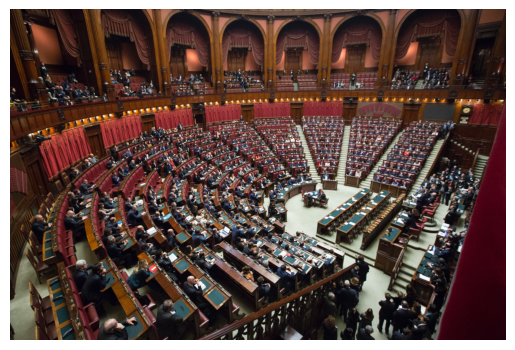

Top 5 matching news articles:
1. Similarity: 0.3059
Hausverbot: Monsanto-Lobbyisten dürfen nicht mehr ins Europaparlament
Weil Monsanto nicht zu einer Anhörung erscheint, dürfen Lobbyisten des Konzerns das Europaparlament nicht mehr betreten. Denn es gibt immer noch Unklarheiten bei der Beurteilung des Pflanzenschutzmittels Glyphosat.
--------------------
2. Similarity: 0.3004
Élysée-Vertrag: "Das Herz unserer Freundschaft schlägt im Parlament"
 Deutschland und Frankreich wollen den Élysée-Vertrag erneuern. Warum ihnen das so wichtig ist, schreiben die Parlamentspräsidenten beider Länder hier auf ZEIT ONLINE.
--------------------
3. Similarity: 0.2980
Störerhaftung: Bundesrat macht Weg frei für WLAN-Gesetz mit Sperranspruch
Nach dem Bundestag hat jetzt auch die Länderkammer einen Gesetzentwurf befürwortet, mit dem Betreiber offener Funknetze die Störerhaftung nicht mehr fürchten müssen. Andererseits drohen mehr Websperren.
--------------------
4. Similarity: 0.2954
Puigdemont unter Auf

In [220]:
show_news_for_img('./Unsplash_pics/marco-oriolesi-wqLGlhjr6Og-unsplash.jpg' , topk=5)

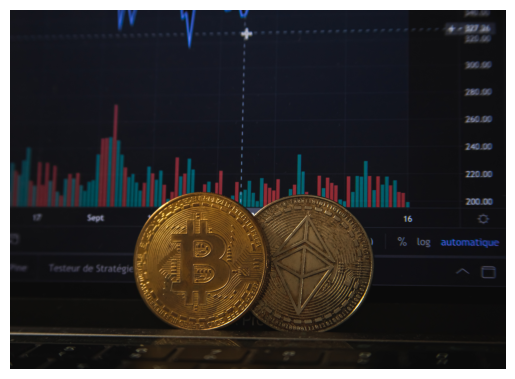

Top 5 matching news articles:
1. Similarity: 0.2943
Sorge vor Regulierung: Bitcoin fällt unter 10.000 Dollar
Die Kryptowährung Bitcoin steht weiter unter Druck. Auf großen Handelsplattformen fiel sie auf den niedrigsten Stand seit zwei Monaten.
--------------------
2. Similarity: 0.2941
Rekordhoch: Bitcoin-Kurs steigt auf mehr als 7000 Dollar
Die Kryptowährung Bitcoin rast von Rekordhoch zu Rekordhoch: Ihr Wert stieg erstmals über die Marke von 7000 Dollar. Allein in den vergangenen Wochen legte der Kurs um 70 Prozent zu.
--------------------
3. Similarity: 0.2921
Bitcoin erstmals bewertet: Ist der Hype gerechtfertigt?
Um Kryptowährungen wie Bitcoin und Ethereum gibt es einen großen Wirbel. Eine US-Ratingagentur hat die digitalen Zahlungsmittel erstmals bewertet.
--------------------
4. Similarity: 0.2918
Währung oder Spekulationsobjekt – das Bitcoin-Dilemma: Zahlen oder Zocken?
Als Währung gedacht, doch vor allem zum Spekulieren genutzt: Der Bitcoin-Höhenflug steht dem ursprünglichen 

In [221]:
show_news_for_img('./Unsplash_pics/pierre-borthiry-peiobty-vBCVcWUyvyM-unsplash.jpg' , topk=5)

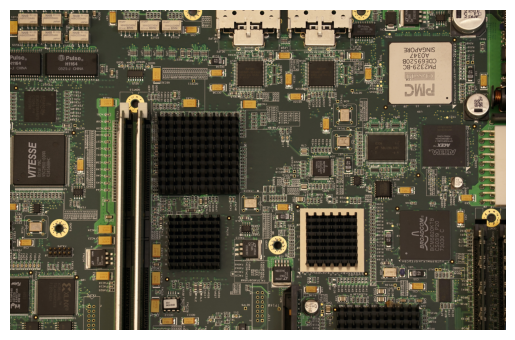

Top 5 matching news articles:
1. Similarity: 0.3085
Prozessor-Lücken Meltdown und Spectre: Intel und ARM führen betroffene Prozessoren auf, Nvidia analysiert noch
Betroffen sind unter anderem sämtliche Intel-Core-Prozessoren bis zurück zum Jahr 2008 sowie eine Vielzahl von ARM-Cortex-CPUs. Nvidia glaubt, dass die CUDA-GPUs nicht anfällig sind und analysiert noch seine Tegra-Prozessoren.
--------------------
2. Similarity: 0.3062
Hunderttausende Infineon-Sicherheits-Chips weisen RSA-Schwachstelle auf
Viele Hardware-Hersteller verbauen Trusted Platform Modules (TPMs) von Infineon. In denen befindet sich bereits seit 2012 eine Lücke, die die Sicherheit von RSA aushebelt. Einige Hersteller haben Sicherheitsupdates veröffentlicht; andere stehen noch aus.
--------------------
3. Similarity: 0.3040
CES: Intel Core i-8000G: Kombiprozessoren mit leistungsfähiger Vega-Grafik für Notebooks
Die leistungsfähigen Quad-Core-CPUs mit AMD-GPU und HBM2-Speicher ersetzen in flachen Notebooks Mobil-Grafik

In [222]:
show_news_for_img('./Unsplash_pics/bartosz-kwitkowski-SJ5TmRRSM1U-unsplash.jpg' , topk=5)

#### <font color="blue"><b>Comment:</b></font> Elaboration ####

Interestingly the Images match very well to the found articles, even though the cosine similarity score is relativly low. Cosine similarity is a metric used to measure the similarity between two vectors, with values ranging from -1 (completely dissimilar) to 1 (completely identical). However, cosine similarity might not always perfectly capture the perceptual similarity between the images and the texts in the context of this specific problem.

When the cosine similarity is relatively low, but the results are still satisfying, it could mean a few things:

1. The embeddings might not be perfectly aligned: Although the embeddings generated by the model may capture some semantic information about the images and texts, they might not be perfectly aligned, causing the cosine similarity scores to be lower than expected. Nevertheless, the ranking of the news articles might still be meaningful.
2. The similarity is relative: In some cases, the absolute value of the cosine similarity might not be that high, but the relative ranking of the news articles could still be relevant. It's possible that the top 5 articles are indeed the best matches among all available articles, even though their similarity scores are not very high.

Low cosine similarity scores do not necessarily imply poor performance. The results can still be satisfactory if the ranking of the most relevant articles is meaningful and accurate. It's crucial to evaluate the results by examining the content of the matched articles and their relevance to the given image rather than relying solely on the cosine similarity scores.

What also can be a reasonable explainantion is that the text do actually fit the picture, but because two encoders (image_encoder and text_encoder) are learned and backpropagated because it is actually a loss.

### Task 3: CLIP for zero-shot text classification

In this experiment, analyze how good CLIP is for zero-shot text classification.
Use `class_prompts = ['Dies ist ein Technischer Text', 'Dies ist ein Genereller Text']` as the zero-shot class text prompts to assign the news articles to one of the two categories.

Then calculate the cosine similarity between the news articles and the text and check which class has the higher similarity. Calculate the accuracy of the zero-shot text classifier. How do you interpret the results?


In [23]:
# Create embeddings for the class prompts
class_prompts = ['Dies ist ein Technischer Text', 'Dies ist ein Genereller Text']

In [24]:
class_prompt_embeddings = text_encoder.encode(class_prompts)

In [25]:
class_prompt_embeddings

array([[-0.06451134,  0.29903698, -0.24779719, ..., -0.13191047,
        -0.26319426,  0.02237925],
       [ 0.04895654,  0.2550691 , -0.1280288 , ..., -0.13320075,
        -0.29511595, -0.03813801]], dtype=float32)

In [26]:
class_prompt_embeddings.shape

(2, 512)

In [27]:
class_prompt_embeddings.__class__

numpy.ndarray

In [28]:
np.save('class_prompt_embeddings.npy', class_prompt_embeddings)

In [29]:
# Encode the texts
text_embeddings = text_encoder.encode(texts)

In [30]:
text_embeddings

array([[ 0.15977994,  0.25762492, -0.25835603, ..., -0.41811368,
         0.0838065 ,  0.11863746],
       [-0.00815743,  0.43600145, -0.10378097, ..., -0.0233734 ,
         0.04435513,  0.2625245 ],
       [ 0.14930476, -0.06335013, -0.15873134, ..., -0.23393425,
         0.10364859,  0.03349249],
       ...,
       [-0.00304341, -0.00858315, -0.03763528, ..., -0.05256917,
         0.02030667, -0.15524314],
       [ 0.12031516,  0.08814149, -0.2556328 , ...,  0.07672176,
         0.2678019 ,  0.09494463],
       [ 0.16784154,  0.11379012, -0.03085276, ...,  0.25524852,
        -0.03525988,  0.13864101]], dtype=float32)

In [31]:
class_prompt_embeddings.shape

(2, 512)

In [32]:
class_prompt_embeddings.__class__

numpy.ndarray

In [33]:
# Calculate the cosine similarity between the text embeddings and class prompt embeddings
cosine_similarity_matrix = cosine_similarity(text_embeddings, class_prompt_embeddings)

In [34]:
cosine_similarity_matrix

array([[0.8557247 , 0.8595626 ],
       [0.7768817 , 0.7784008 ],
       [0.87497014, 0.87871766],
       ...,
       [0.7835331 , 0.79085314],
       [0.8175785 , 0.81206006],
       [0.8737849 , 0.8776092 ]], dtype=float32)

In [35]:
predicted_labels = np.argmax(cosine_similarity_matrix, axis=1)

In [36]:
predicted_labels.shape

(3315,)

In [37]:
predicted_labels

array([1, 1, 1, ..., 1, 0, 1])

In [64]:
# Print the real labels, predicted labels, the text, and the similarity scores
for i in range(len(texts)):
    real_label = labels[i]
    predicted_label = predicted_labels[i]
    text = texts[i]
    cosine_similarity_scores = cosine_similarity_matrix[i]
    
    print(f"Real label: {real_label}, Predicted label: {predicted_label}")
    print(f"Similarity scores: Tech = {cosine_similarity_scores[0]:.4f}, General = {cosine_similarity_scores[1]:.4f}")
    print(f"Text: {text}\n{'-' * 20}\n")

Real label: 0, Predicted label: 1
Similarity scores: Tech = 0.8557, General = 0.8596
Text: Gestaltungstipps: T-Shirts bedrucken
Bedruckte T-Shirts sind ein All-Time-Favorite – egal, ob witzige Comic-Motive oder schlichte Formen. Tipps und Ideen rund um die Gestaltung.
--------------------

Real label: 0, Predicted label: 1
Similarity scores: Tech = 0.7769, General = 0.7784
Text: Software-Charts: Die 50 Top-Downloads des Monats
CCleaner ist gehackt, die sichere neue Fassung laden Sie hier – samt Vollversionen: das Ashampoo Music Studio und PowerDirector.
--------------------

Real label: 0, Predicted label: 1
Similarity scores: Tech = 0.8750, General = 0.8787
Text: Quereinsteiger-Jobs: So gelingt der Wechsel
Der Quereinstieg in eine neue Branche ist heute nicht mehr ungewöhnlich. Fragen und Tipps, die beim beruflichen Neustart helfen können.
--------------------

Real label: 0, Predicted label: 0
Similarity scores: Tech = 0.7580, General = 0.7546
Text: Highspeed für Düsseldorf: Die güns

In [38]:
# Calculate the accuracy of the zero-shot text classifier
accuracy = accuracy_score(labels, predicted_labels)
print(f"Zero-shot text classification accuracy: {accuracy * 100:.2f}%")

Zero-shot text classification accuracy: 82.59%


#### <font color="blue"><b>Comment:</b></font> Elaboration ####
An accuracy of ~82% indicates that the zero-shot text classifier using the CLIP model is able to correctly classify about 82% of the news articles into their respective categories ('Technischer Text' and 'Genereller Text'). In this context, the performance can be considered reasonably good. This reasoning can be further be cemented by the fact, that the classes 'General Text' or 'Technical Text' are similar distributed in the dataset so there is little bias to the 'larger' class.

### Task 4: CLIP for text-to-text retrieval

Define a function `show_news_for_keywords(keywords, topk=5)`, which takes a string as input and an integer topk that defines how many of the best matching news articles should be displayed. For evaluation, try out some different keywords such as `Sport Fußball` or `Donald Trump` and interpret the best matching news articles. What final conclusions can you draw about the CLIP model? Why do you think CLIP shows this kind of behavior? 

The function should always display the keywords and then the top news articles, as well as the similarity of the news article to the keywords.

In [39]:
def show_news_for_keywords(keywords, topk=5):
    # Encode the input keywords
    keyword_embedding = text_encoder.encode([keywords])[0]

    # Reshape the keyword_embedding
    keyword_embedding = keyword_embedding.reshape(1, -1)

    # Calculate the cosine similarity between the keyword embedding and text embeddings
    similarities = cosine_similarity(keyword_embedding, text_embeddings).flatten()

    # Get the indices of the top-k most similar news articles
    topk_indices = similarities.argsort()[-topk:][::-1]

    # Display the input keywords
    print(f"Keywords: {keywords}\n")

    # Display the top-k matching news articles and their similarity scores
    print(f"Top {topk} matching news articles:")
    for i, idx in enumerate(topk_indices, start=1):
        print(f"{i}. Similarity: {similarities[idx]:.4f}\n{texts[idx]}\n{'-' * 20}")

        print("")

In [40]:
show_news_for_keywords("Sport Fußball", topk=5)
print("="*40)
show_news_for_keywords("Donald Trump", topk=5)
print("="*40)
show_news_for_keywords("Amazon", topk=5)
print("="*40)
show_news_for_keywords("Regierung", topk=5)


Keywords: Sport Fußball

Top 5 matching news articles:
1. Similarity: 0.9149
Videobeweis: Im Darkroom des Fußballs
 Der Videobeweis sollte den Fußball gerechter machen. Das klappte nur selten. Mit der Entmachtung Hellmut Krugs zeigt sich sogar ein ganz anderer Verdacht.
--------------------

2. Similarity: 0.9004
Freuen, bitte
Der FCA schlägt nach dem 0:1 schnell zurück, wütet gegen den Video-Schiedsrichter - und beweist, ein unangenehmer Gegner zu sein.
--------------------

3. Similarity: 0.8994
Der Traum vom Gymnasium
Die Gemeinde bringt sich vorsichtig als Standort ins Spiel.
--------------------

4. Similarity: 0.8980
Videobeweis: In vielen Sportarten längst etabliert
Seit dieser Saison wird der Videobeweis in der Fußball-Bundesliga eingesetzt – zunächst in einer Testphase. Vieles läuft nicht reibungslos. Andere Sportarten sind schon viel weiter.
--------------------

5. Similarity: 0.8897
„Tester bei der USK zu sein ist der absolute Traumjob“
Die USK prüft, ab welchem Alter ein V

#### <font color="blue"><b>Comment:</b></font> Elaboration ####
With these similarites, one can indicate that text-to-text retrieval with CLIP works pretty well. The model can find effectively find content in the dataset, related to the given keyword.

### Bonus: Image-to-image retrieval with CLIP

As an bonus experiment you can test, how good CLIP is for image-to-image retrieval. This should be straightforward to implement, since you already know, how to use clip for image-to-text and text-to-text retrieval. 

What hypothesis do you have regarding the performance of CLIP's image-to-image capabilities? 

In [242]:
def show_similar_images(img_path, topk=5):
    # Load the input image
    input_img = Image.open(img_path).convert('RGB')

    # Create an embedding for the input image
    with torch.no_grad():
        input_img_embedding = image_encoder.encode([input_img])[0]

    # Reshape the input_img_embedding
    input_img_embedding = input_img_embedding.reshape(1, -1)

    # Calculate the cosine similarity between the input image embedding and all image embeddings
    similarities = cosine_similarity(input_img_embedding, image_embeddings).flatten()

    # Get the indices of the top-k most similar images
    topk_indices = similarities.argsort()[-topk:][::-1]

    # Display the input image
    plt.imshow(input_img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Display the top-k similar images and their similarity scores
    print(f"Top {topk} similar images:")
    for i, idx in enumerate(topk_indices, start=1):
        img = Image.open(image_files[idx]).convert('RGB')
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Similar Image {i}: Similarity {similarities[idx]:.4f}")
        plt.show()

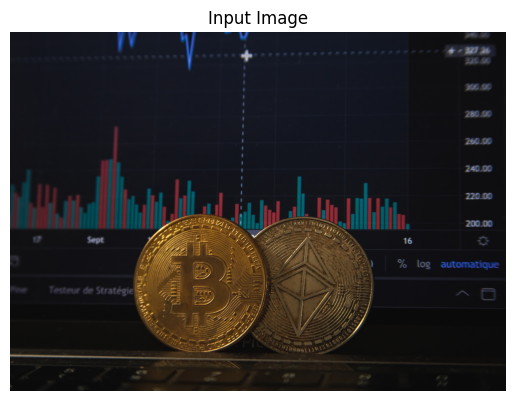

Top 5 similar images:


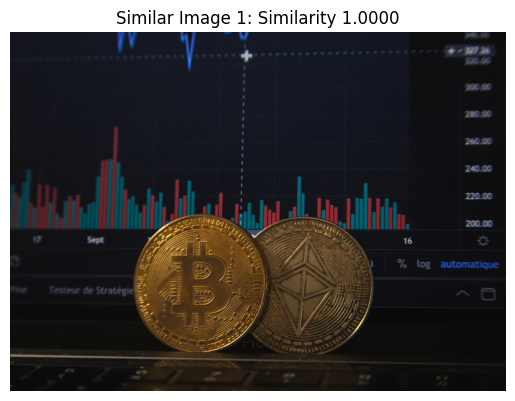

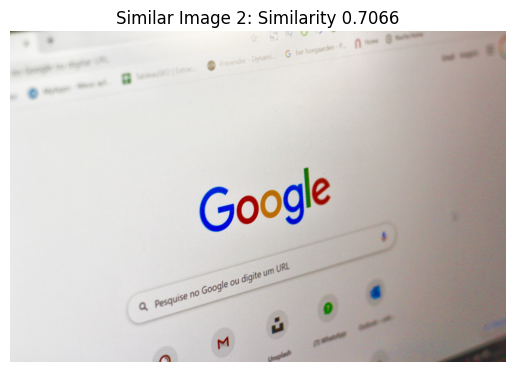

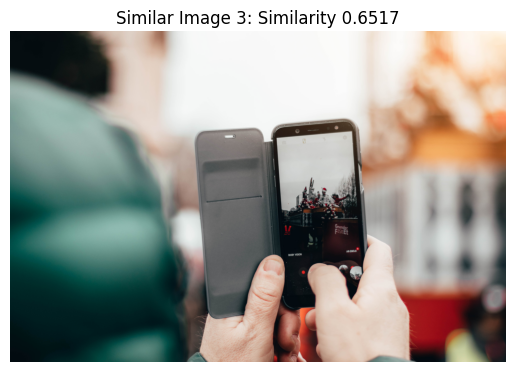

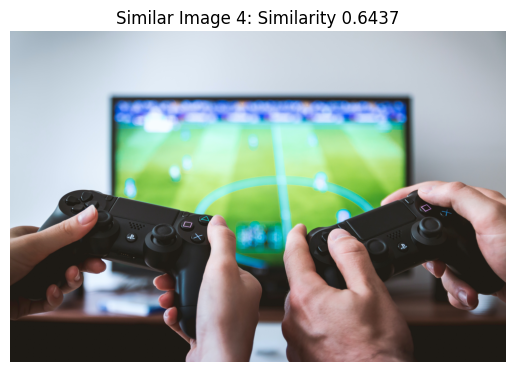

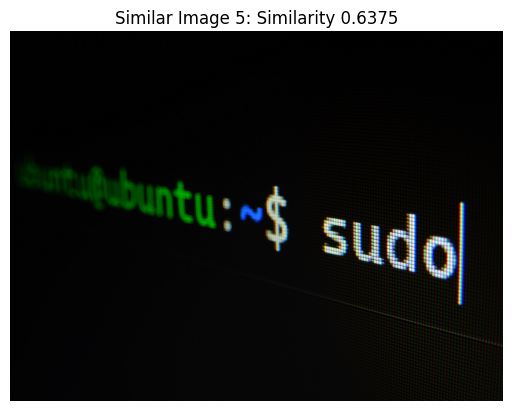

In [244]:
# Test the function with an example image
show_similar_images('./Unsplash_pics/pierre-borthiry-peiobty-vBCVcWUyvyM-unsplash.jpg', topk=5)

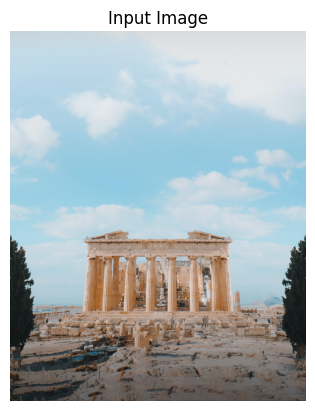

Top 5 similar images:


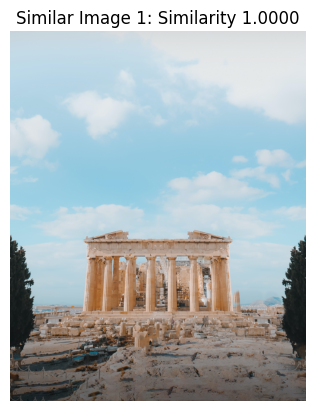

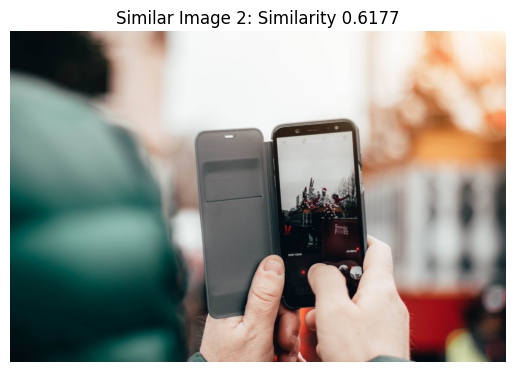

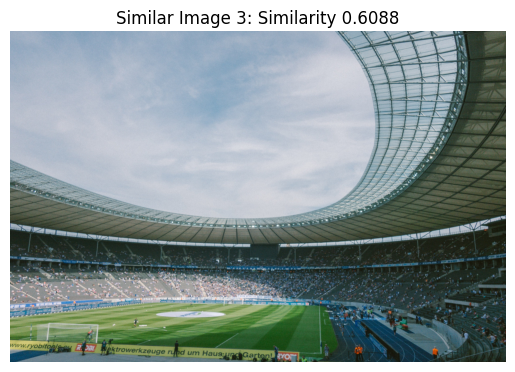

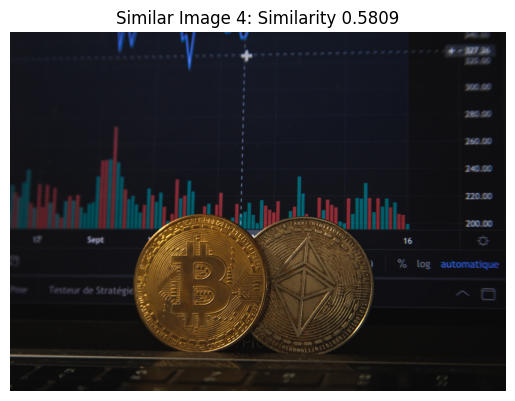

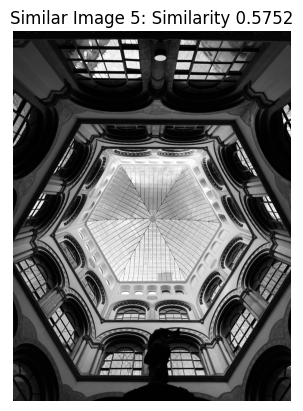

In [245]:
show_similar_images('./Unsplash_pics/pat-whelen-cHvyUM-kXoA-unsplash.jpg' , topk=5)

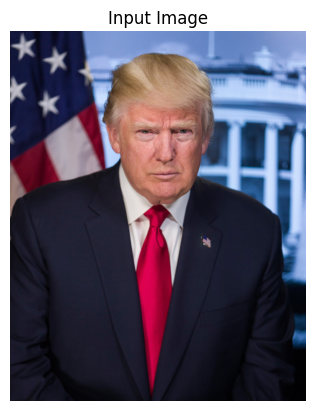

Top 5 similar images:


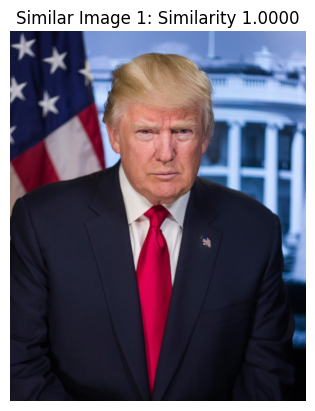

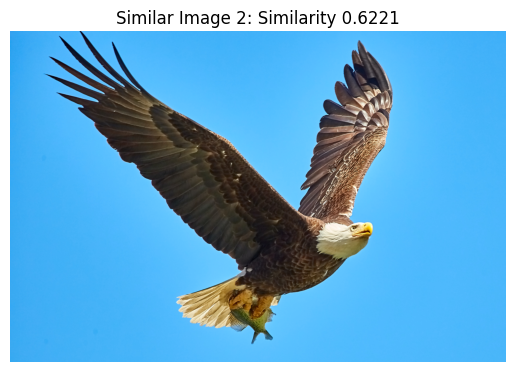

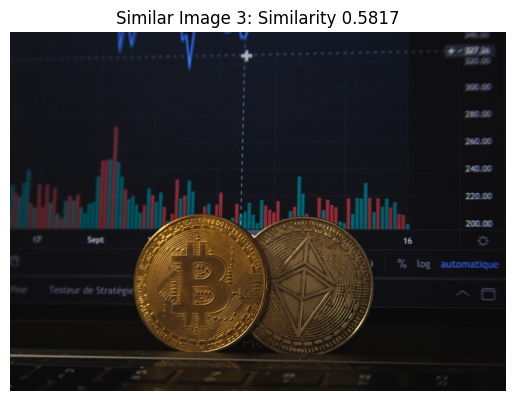

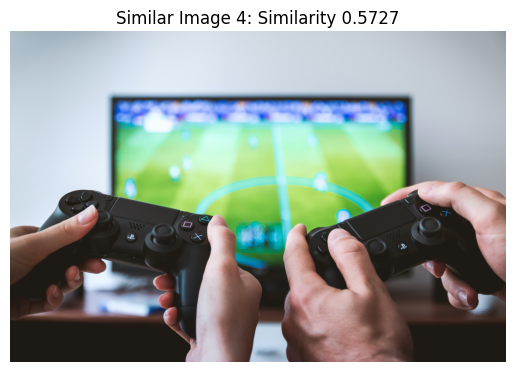

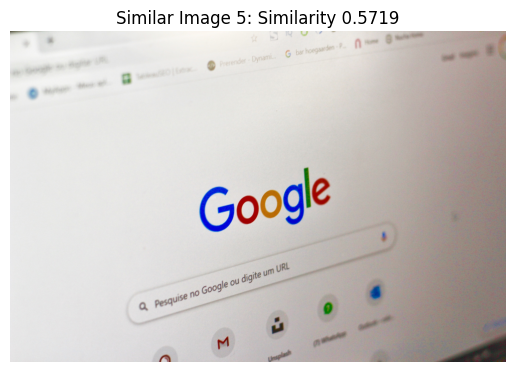

In [246]:
show_similar_images('./Unsplash_pics/trump.jpg' , topk=5)

#### <font color="blue"><b>Comment:</b></font> Elaboration ####

CLIP models primarily serve to enable image-to-text and text-to-image search tasks. Nonetheless, their extensive training on vast quantities of image-text pairs suggests they may also be adept at image-to-image retrieval. By learning meaningful characteristics for both images and text, CLIP models generate embeddings that can be employed for efficient comparison and retrieval of similar images.

While it's essential to recognize that models explicitly created for image-to-image retrieval could potentially surpass CLIP in this area, the model's design and training on image-text pairs indicate it should still provide adequate performance for such tasks.

# Part 6: Semantic Search with only text-based model

In the final experiment, we will use the [Multilingual Universal Sentence Encoder for Semantic Retrieval](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html) model for text-to-text retrieval. 
The model name is `distiluse-base-multilingual-cased-v1`.

CLIP uses one image and one text encoder to link text and images. In contrast this model uses a shared text encoder as it only computes embeddings for text passages. Instead of image-text pairs, we have text-text pairs, where one text is a paragraph (similar to the image) and the other text is similar to the caption. The model is trained in a multi-task setting. The following picture shows the training objectives for each task. All tasks receive two text segments as input and in addition, the question answering and translation tasks have almost the same objective as CLIP, which is to match one text block to another text block. 

<img src="Pics/use-model.png" width=500 />
(img src: https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html)

Recalculate the text embeddings for all news articles with the new model. Then perform the same experiments as in part 5 task 3 and task 4. It should be possible to use the same method `show_news_for_keywords(keywords, topk=5)` as in the previous experiment.

Interpret the accuracy of the zero-shot text classification experiment compared to the experiment before? 
How good is the news article retrieval system for the same keywords as in part 5 task 4?

In [41]:
model_use = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [42]:
# Compute the text embeddings for all news articles
text_embeddings_use = model_use.encode(texts)

In [43]:
text_embeddings_use

array([[ 0.00713734, -0.06721587, -0.01899256, ...,  0.08092853,
        -0.04419863, -0.00068567],
       [ 0.03781124,  0.03158962, -0.00089721, ...,  0.08101284,
        -0.02077485, -0.00132351],
       [ 0.06377002, -0.0561986 ,  0.03984799, ...,  0.04627963,
         0.00434085,  0.03345149],
       ...,
       [ 0.06854702, -0.07621833,  0.01771633, ..., -0.00069934,
        -0.01060178,  0.00470881],
       [ 0.01391089,  0.00744342,  0.06594236, ..., -0.00647332,
        -0.05001034, -0.03736248],
       [ 0.01673926, -0.08296122, -0.04486099, ..., -0.07075141,
         0.05577121,  0.08739865]], dtype=float32)

In [44]:
text_embeddings_use.shape

(3315, 512)

In [45]:
text_embeddings_use.__class__

numpy.ndarray

In [53]:
# Save the computed embeddings for later use
np.save('text_embeddings_use.npy', text_embeddings_use)

In [56]:
def show_news_for_keywords_use(keywords, topk=5):
    # Encode the keywords using the USE model
    keywords_embedding = model_use.encode([keywords])[0].reshape(1, -1)

    # Calculate the cosine similarity between the keywords embedding and all text embeddings
    similarities = cosine_similarity(keywords_embedding, text_embeddings_use).flatten()

    # Get the indices of the top-k most similar news articles
    topk_indices = similarities.argsort()[-topk:][::-1]

    # Display the keywords
    print(f"Keywords: {keywords}\n")

    # Display the top-k matching news articles and their similarity scores
    print(f"Top {topk} matching news articles:")
    for i, idx in enumerate(topk_indices, start=1):
        print(f"{i}. Similarity: {similarities[idx]:.4f}\n{texts[idx]}\n{'-' * 20}")


In [57]:
show_news_for_keywords_use('Sport Fußball', topk=5)
print("="*40)
show_news_for_keywords_use('Donald Trump', topk=5)
print("="*40)
show_news_for_keywords_use('Amazon', topk=5)
print("="*40)
show_news_for_keywords_use('Regierung', topk=5)

Keywords: Sport Fußball

Top 5 matching news articles:
1. Similarity: 0.4156
Videobeweis: In vielen Sportarten längst etabliert
Seit dieser Saison wird der Videobeweis in der Fußball-Bundesliga eingesetzt – zunächst in einer Testphase. Vieles läuft nicht reibungslos. Andere Sportarten sind schon viel weiter.
--------------------
2. Similarity: 0.3074
Missbrauch im Sport: Das Recht auf eine Grenze
Nach jahrzehntelangem Schweigen melden sich immer mehr Athleten zu Wort, die im Sport Opfer sexuellen Missbrauchs wurden. Die Sportverbände reagieren mit beachtlichen Präventionsmaßnahmen – aber reicht das?
--------------------
3. Similarity: 0.2941
Fußball-Bundesliga: Frankfurt gegen Bremen live sehen!
Im heutigen Bundesliga-Freitagsspiel treffen Frankfurt und Bremen aufeinander. COMPUTER BILD erklärt, wie und wo die Partie live übertragen wird.
--------------------
4. Similarity: 0.2862
"Nach Rio habe ich überlegt aufzuhören"
Deutsche Spitzensportler müssen teils mit wenigen Hundert Euro im 

#### <font color="blue"><b>Comment:</b></font> Elaboration ####
These are interestingly low although the first 5 articles seem to make sense or at least have a context on the first sight to the keyword. The vast difference of the cosine similarities between **clip-ViT-B-32-multilingual-v1 (CLIP)** and **distiluse-base-multilingual-cased-v1 (USE)** is attributed to the way these models have been trained. The distiluse-base-multilingual-cased-v1 model is a text-only model derived from the Universal Sentence Encoder (USE) family, specifically designed for semantic similarity tasks. It is trained on a variety of text-text pairs and learns to generate meaningful embeddings for text passages. However, its training data may not be as diverse or well-aligned with the specific domain of our news articles, leading to lower cosine similarity scores.

On the other hand, CLIP model is trained on a large dataset of image-text pairs, which helps it learn meaningful features for both images and text. CLIP learns the relationships between visual and textual information, allowing it to generate embeddings that capture a shared semantic space between images and text. As a result, it may be more capable of capturing the semantic similarity between keywords and news articles, leading to higher cosine similarity scores.

# Further ideas

#### This is not part of the official notebook!!! 

This was part of the old notebook, where LSTM and CNN models were trained on top of the word2vec-embeddings for text classification and can be used for further experiments/ideas. 

## Tasks on Text Classification

In this section a CNN document classifier shall be defined, trained and evaluated with Keras. For this the basics of Keras, as described e.g. in this [Keras Tutorial](https://keras.io/about/), must be known. 

The classifier shall be able to distinguish RSS-feed news with technical content from general RSS-feed news. Training and evaluation data is available from the folder `./Data/GERMAN/`.  

### Access locally stored RSS-feed news of both categories 
News crawled from RSS feeds of category `Tech` and `General` are stored in distinct directories. In the following code-cell the paths to both directories are configured. 

In [ ]:
techpath="./Data/GERMAN/TECH/RSS/FeedText"
generalpath="./Data/GERMAN/GENERAL/RSS/FeedText"
catpaths=[techpath,generalpath]

The specified directory `techpath` must contain a list of directories. The name of each of these directories is the name of the feed, from which the news are crawled attached by the date of crawling. For example one subdirectory may be `golem-2017-11-07`. Each of this feed-and-date-specific subdirectories conatins one or more `.txt`-files. The name of each of these `.txt`-files is of format `hh-mm.txt`, i.e. it contains the daytime of crawling. If one feed is crawled multiple times per day, the feed-and-date-specific subdirectories will contain more than one `.txt`-files, each identified by the time of crawling. Below, the first lines of a sample `.txt`-file, `15-15.txt` from directory `golem-2017-11-07` are shown. Each paragraph of the file is a single news item from the *golem RSS feed*, crawled at 2017-11-07, 15.51h.

![Screenshot of feedfile](./Pics/feedfile.png)



In the following code-cell all news from all files are imported. All news from subdirectories of `techpath` are assigned to the class `Tech` (label 0) and all news from subdirectories of `generalpath` are assigned to class `GENERAL` (label 1). Each news-item is represented as a list of words, contained in the item. All item-specific word-lists are assigned to the list `texts` and the corresponding class-indices are assigned to the list `labels`. Before news-item specific word lists are appended to the `texts`-list it is checked, if they are not yet contained in this list.  

In [ ]:
# second, prepare text samples and their labels
print('Processing text dataset')
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for catlabel,categorypath in enumerate(catpaths):
    for name in sorted(os.listdir(categorypath)):
        feedpath = os.path.join(categorypath, name)
        if os.path.isdir(feedpath):
            #print(name)
            for fname in sorted(os.listdir(feedpath)):
                fpath = os.path.join(feedpath, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='utf-8')
                t = f.read()
                news=t.split('\n \n')
                for entry in news:
                    if (len(entry)>50) and (entry not in texts): #remove duplicates
                        #if entry not in texts:
                        texts.append(entry)
                        labels.append(catlabel)
                f.close()
print('Found %s texts.' % len(texts))

In [ ]:
print(texts[0])
print("-"*20)
print(texts[1])
print("-"*20)
print(texts[2])

### Convert texts to sequence of integers

#### Task 10: Transform each text into a sequence of integers
Apply the [Keras Tokenizer class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) in order to uniquely map each word to an integer-index and to represent each text (news-item) as a sequence of integers. The maximum number of words regarded in the Tokenizer shall be `MAX_NB_WORDS=10000`. After fitting the `Tokenizer`-object with the available texts (`fit_on_texts()`), it's attribute `tokenizer.word_index` maps each word to an integer-index. 

#### Task 11: Visualize distribution of document lengths
Visualize the distribution of document lengths in a histogram.

#### Task 12: Pad sequences to unique length
Next the [Keras function pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) shall be applied to represent the set of all sequences as a numpy-array. The number of rows in this array is the number of sequences, the number of columns is the fixed sequence length `maxlen`. Choose an appropriate value for the fixed sequence length. 

Moreover, the labels-list shall be one-hot-encoded into a numpy-array `labels` with two columns. In this array the entry in row i, column j is 1, if the i.th text belongs to the class with label j, otherwise this entry is 0.

### Split labeled texts in training- and validation set

#### Task 13: Create training- and validation-partition
The numpy-array of padded integer-sequences and the corresponding labels (as generated in the code cell above) shall be randomly shuffled and then split into a training- and a validation set. 80% of the labeled data is applied for training, the remaining 20% for validation. 

### Load  and prepare Word-Embedding

#### Task 14: Load Word Embedding
Load the Word Embedding, which has been trained and saved in task 3.

#### Task 15: Prepare `embeddings_index`
Next a Python dictionary `embeddings_index`, which maps words to their vector-representation must be generated.

#### Task 16:  Prepare `embeddings_matrix`

The variable `word_index` has been allocated in **Task 10**. It maps each word of the labeled documents (news) to a unique index. Now `word_index` as calculated from the labeled input documents for the classifier is combined with the `embedding_index`, which maps each word of the word-embedding (German wikipedia dump in this case) to it's vector representation. The result is the *numpy-array* `embedding_matrix`, which contains in the i.th row the vector representation of the word with index i in the `word_index`. Applying this `embedding_matrix` allows the *Keras*-module `Embedding` to map a sequence of word-indices, which represents a single news-item, to a sequence of word-vectors. 

![wordMappings](./Pics/wordMappings.png)



### Define CNN architecture, train and evaluate
In Keras network architectures can either be defined as [Sequential models](https://keras.io/guides/sequential_model/) or by the [Functional API approach](https://keras.io/guides/functional_api/). For the implementations in this lecture you are free to choose any of both. 

#### Task 17: Define CNN architecture
The `embedding_matrix`, as generated in the previous task shall now be assigned to the `weights`-argument of a [Keras Embedding Layer](https://keras.io/api/layers/core_layers/embedding/). The Embedding Layer constitutes the input layer of the CNN. 

Following the input layer configure one or more cascades of `Conv1D`-layers, followed by `MaxPooling1D`-layers. Apply `relu`-activation in the conv-layers. 


After the last convolutional-layer a `GlobalMaxPooling1D`-layer shall be applied, followed by a dense layer with softmax-activation (for the binary classification actually a sigmoid-activation at the output would be enough).

Display a summary of this architecture by calling the `summary()`-function.

#### Task 18: Define Training
Hyperparameters for training a Keras model are defined by applying the `compile()`-method. Use `binary_crossentropy` as loss-function, `rmsprop` as learning-algorithm (optimizer) and `accuracy` as metric. 

#### Task 19:  Training and Validation
Apply the model's `fit()`-method for training. Assign training- and validation- data as generated in Task 13. Choose an appropriate `batch_size` and an appropriate number of `epochs`. 

After training is finished, plot the accuracy on the training- and validation-data over the epochs.

### Optimization
#### Task 20: Optimize CNN Architecture
Find a good CNN configuration by varying hyperparameters, such as number of layers, number of filters, filtersizes, etc. 


## Further ideas
If no embedding_matrix is assigned to the `weights`-argument of the `EmbeddingLayer` and the `trainable`-argument is set to be `True`, then the weights of the EmbeddingLayer are learned during training of the entire network. I.e. in this case no pre-trained word-embedding is required. It would be nice to compare this approach with the approach where pre-trained weights are applied. 

As an alternative to the CNN a LSTM-architecture, e.g. a single LSTM-Layer, followed by Dropout and a Dense Layer at the output, can be applied for classification. The input-embedding layer would be the same as for the CNN. 